In [2]:
import sys,os
add_path = os.path.abspath('../python')
if not add_path in sys.path:
    sys.path.append(add_path)
print(sys.path.index(add_path))
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
import segbench
from segbench import interp3, edgeNms3d, correspondVoxels

In [6]:
A = np.array(range(0,27)).reshape(3,3,3)

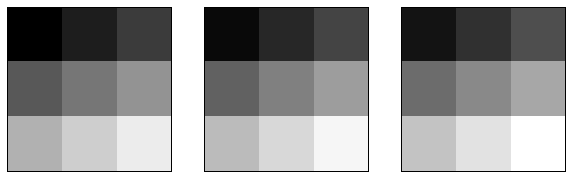

In [7]:

vmin,vmax = A.min(),A.max()
fig = plt.figure(figsize = (10,10))
for i in range(0,A.shape[2]):
    ax = plt.subplot(1,3,i+1)
    ax.imshow(A[:,:,i],vmin=vmin,vmax=vmax)
    ax.set_xticklabels([]);ax.set_yticklabels([])
    ax.yaxis.set_ticks_position('none');ax.xaxis.set_ticks_position('none')

In [8]:
K = 3*2-1
x,y,z = np.linspace(0,2,K),np.linspace(0,2,K),np.linspace(0,2,K)
X,Y,Z = np.meshgrid(x,y,z)
B = np.zeros((K,K,K))
for xi,yi,zi in zip(X.ravel(),Y.ravel(),Z.ravel()):
    B[int(xi*2),int(yi*2),int(zi*2)] = interp3(A,xi,yi,zi)
print B.shape

(5, 5, 5)


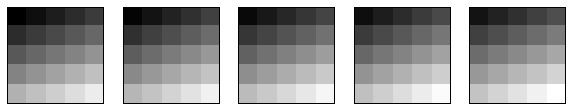

In [9]:
vmin,vmax = B.min(),B.max()
fig = plt.figure(figsize = (10,10))
for i in range(0,B.shape[2]):
    ax = plt.subplot(1,B.shape[2],i+1)
    ax.imshow(B[:,:,i],vmin=vmin,vmax=vmax)
    ax.set_xticklabels([]);ax.set_yticklabels([])
    ax.yaxis.set_ticks_position('none');ax.xaxis.set_ticks_position('none')

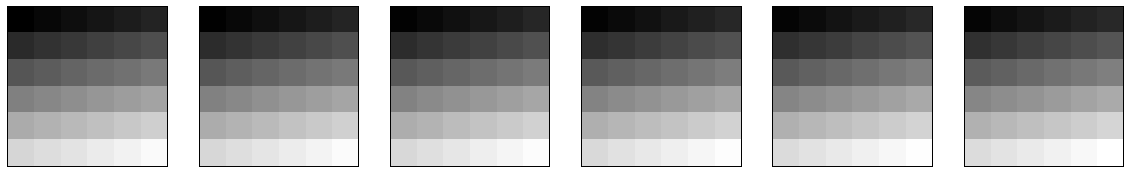

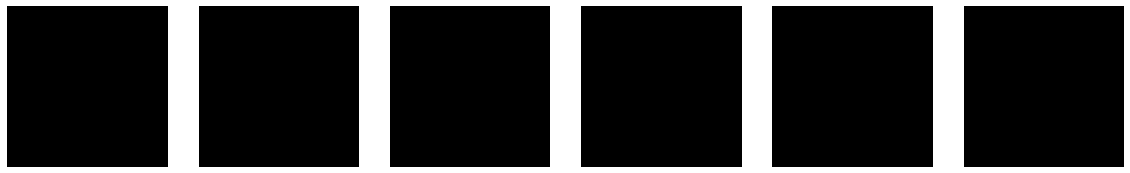

In [10]:
M = 6
A = np.array(range(0,M**3)).reshape(M,M,M)

N = 1
K = M*N
x,y,z = np.linspace(0,M-1,K),np.linspace(0,M-1,K),np.linspace(0,M-1,K)
X,Y,Z = np.meshgrid(x,y,z)
B = np.zeros((K,K,K))
vmin,vmax = B.min(),B.max()
for xi,yi,zi in zip(X.ravel(),Y.ravel(),Z.ravel()):
    B[int(xi*N),int(yi*N),int(zi*N)] = interp3(A,xi,yi,zi)
vmin,vmax = B.min(),B.max()
fig = plt.figure(figsize = (20,20))
for i in range(0,B.shape[2]):
    ax = plt.subplot(1,B.shape[2],i+1)
    ax.imshow(B[:,:,i],vmin=vmin,vmax=vmax)
    ax.set_xticklabels([]);ax.set_yticklabels([])
    ax.yaxis.set_ticks_position('none');ax.xaxis.set_ticks_position('none')
fig = plt.figure(figsize = (20,20))
C = A-B
for i in range(0,C.shape[2]):
    ax = plt.subplot(1,C.shape[2],i+1)
    ax.imshow(C[:,:,i],vmin=vmin,vmax=vmax)
    ax.set_xticklabels([]);ax.set_yticklabels([])
    ax.yaxis.set_ticks_position('none');ax.xaxis.set_ticks_position('none')

In [67]:
import sys,os
add_path = os.path.abspath('../python')
import matplotlib as mpl
from matplotlib import colors
if not add_path in sys.path:
    sys.path.append(add_path)
print(sys.path.index(add_path))
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['image.interpolation'] = 'hanning'
plt.rcParams['image.cmap'] = 'gray'
import segbench
from segbench import interp3, edgeNms3d, correspondVoxels, correspondPixels
import skimage
from skimage.filters import gaussian_filter
import SimpleITK as sitk
def normalimg(E):
    if (E.max()-E.min())>0:
        return (E-E.min())/(E.max()-E.min())
    else:
        return E
def edgeOrientation(E,s=1):
    D = normalimg(gaussian_filter(E,s))
    Ox,Oy,Oz = np.gradient(D)
    M = np.sqrt(Ox*Ox+Oy*Oy+Oz*Oz)
    Ox,Oy,Oz = (Ox,Oy,Oz)/M
    theta = np.arctan(Oy/(Oz+1e-5))
    phi = np.arctan(Oz/(M+1e-5))
    Px= np.sin(theta)*np.cos(phi)
    Py= np.sin(theta)*np.sin(phi)
    Pz= np.cos(phi)
    return Px,Py,Pz,D
    
def plot_vol(V,num_frames=4):
    vmin,vmax = V.min(),V.max()
    ds = V.shape
    frame_list = map(int,np.arange(0,ds[2],np.floor(ds[2]/num_frames)))
    for i,f in enumerate(frame_list):
        ax = plt.subplot(1,ds[2],i+1)
        ax.imshow(V[:,:,f],vmin=vmin,vmax=vmax)
        ax.set_xticklabels([]);ax.set_yticklabels([])
        ax.yaxis.set_ticks_position('none');ax.xaxis.set_ticks_position('none')
        
def plot_vol_overlay(im,red=None,green=None,blue=None,num_frames=4):

    ds = im.shape
    z = np.zeros_like(im)
    red = z if red is None else normalimg(red)*im.max()
    blue = z if blue is None else normalimg(blue)*im.max()
    green = z if green is None else normalimg(green)*im.max()
    
    frame_list = map(int,np.arange(0,ds[2],np.floor(ds[2]/num_frames)))
    
    Is = [im[:,:,i] for i in frame_list]
#     red_lst = [np.dstack((np.ma.masked_where(red[:,:,i]>0,red[:,:,i]),
#                           z[:,:,i],z[:,:,i])) for i in frame_list]
    red_lst = [np.ma.masked_where(red[:,:,i]==0,red[:,:,i]) for i in frame_list]
    green_lst = [np.ma.masked_where(green[:,:,i]==0,green[:,:,i]) for i in frame_list]
    blue_lst = [np.ma.masked_where(blue[:,:,i]==0,blue[:,:,i]) for i in frame_list]
    for i,I in enumerate(Is):
        ax = plt.subplot(1,ds[2],i+1)
        ax.imshow(I)
        ax.imshow(red_lst[i],cmap=colors.ListedColormap(['red']),
                  interpolation='hanning',alpha=.5)
        ax.imshow(green_lst[i],cmap=colors.ListedColormap(['green']),
          interpolation='hanning',alpha=.5)
        ax.imshow(blue_lst[i],cmap=colors.ListedColormap(['blue']),
          interpolation='hanning',alpha=.5)
        ax.set_xticklabels([]);ax.set_yticklabels([])
        ax.yaxis.set_ticks_position('none');ax.xaxis.set_ticks_position('none')
def thin(img):
    return sitk.GetArrayFromImage(sitk.BinaryThinning(sitk.GetImageFromArray(img.astype(int))))
def dilate(img):
    return sitk.GetArrayFromImage(sitk.BinaryDilate(sitk.GetImageFromArray(img.astype(int))))

14


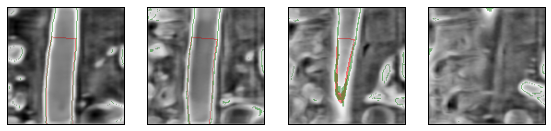

In [74]:
plt.rcParams['image.interpolation'] = 'hanning'
E = np.load("3dEdgeE.npy")
GT = np.load("3dEdgeGT.npy")
E = normalimg(E)
# E = gaussian_filter(E,1)
vmin,vmax = E.min(),E.max()
dX, dY, dZ, D = edgeOrientation(E,s=15)
Enms = edgeNms3d(E, dY,dX, dZ, r=.8, s=0, m=1.01)
Enms = normalimg(Enms)
ds = E.shape
num_frames = 4

# fig = plt.figure(figsize = (80,80))
# plot_vol(1-E,num_frames)

# fig = plt.figure(figsize = (80,80))
# plot_vol(1-GT,num_frames)
Et = thin(Enms>.8)*E
fig = plt.figure(figsize = (80,80))
plot_vol_overlay(normalimg(E),green=Et,red=(GT>0),num_frames=num_frames)



In [75]:
match1 = list()
match2 = list()
for i in range(Enms.shape[-1]):
    cost,oc,m1,m2 = correspondPixels(Et[:,:,i].astype(float),GT[:,:,i].astype(float),.0075)
    print oc,
    match1.append(m1);match2.append(m2)
match1 = np.dstack(match1)
match2 = np.dstack(match2)

cost,oc,match1vol,match2vol = \
correspondVoxels((Et>0).astype(float),(GT>0).astype(float),.0075,10)
print "\n",oc
print(np.sum((match1>0)),np.sum((match1vol>0)))




1357.64501988 1357.64501988 1357.64501988 1357.64501988 1357.64501988 1357.64501988 1357.64501988 1357.64501988 1357.64501988 1357.64501988 1357.64501988 1357.64501988 1357.64501988 1357.64501988 1357.64501988 1357.64501988 1357.64501988 1357.64501988 1357.64501988 1357.64501988 1357.64501988 1357.64501988 1357.64501988 1357.64501988 1357.64501988 1357.64501988 1357.64501988 1357.64501988 1357.64501988 1357.64501988 1357.64501988 1357.64501988 
1378.69503517
(4024, 4271)


In [ ]:
mm1 = (match1vol>0)*((Et>0)) # True Positives
mm2 = (match1match==0)*(GT>0) #things in 2d that didn't match

1378.69503517


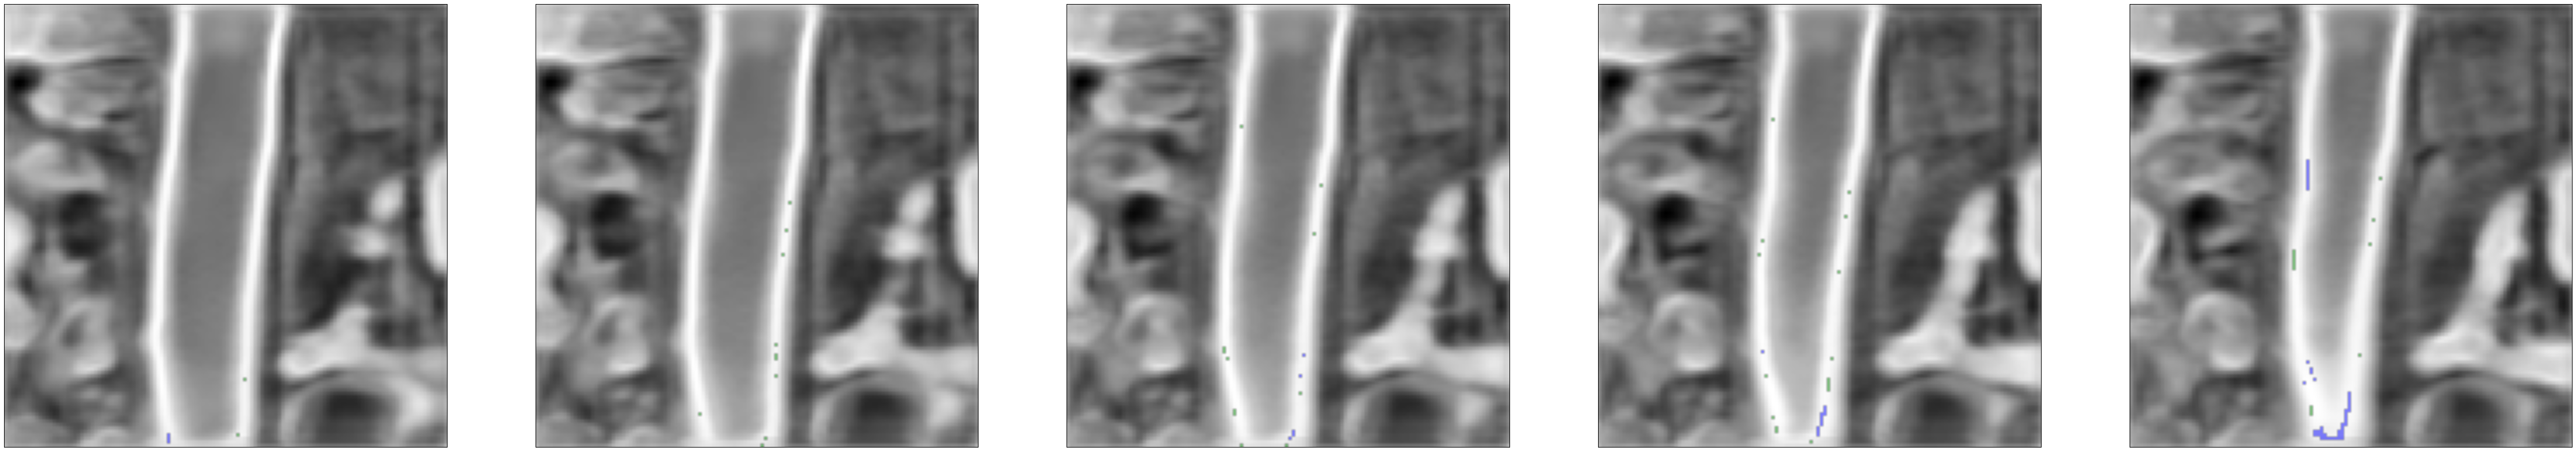

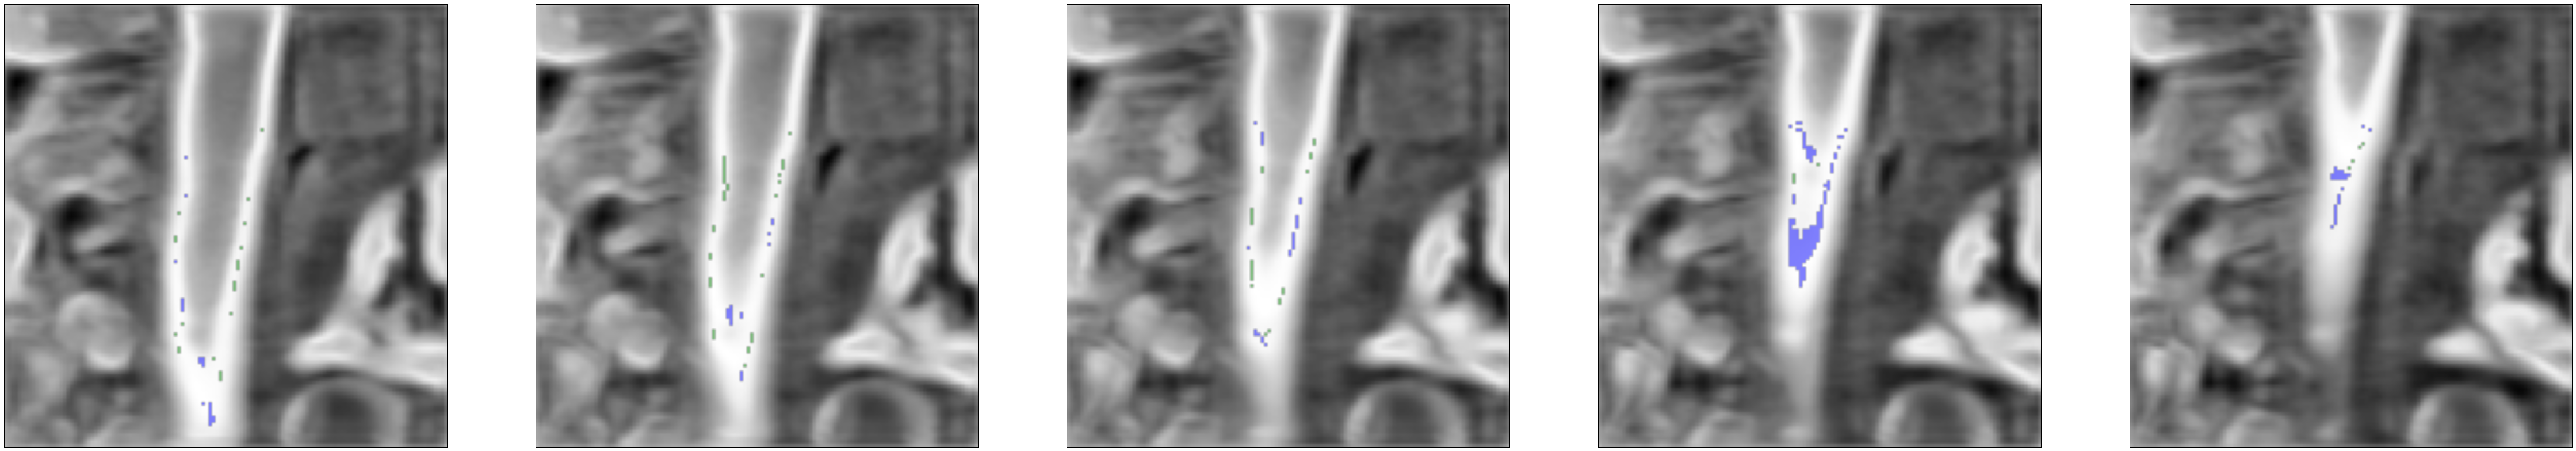

In [90]:
cost,oc,match1match,match2match = \
correspondVoxels((match1vol>0).astype(float),(match1>0).astype(float),.0075,10)
num_frames = 4

# fig = plt.figure(figsize = (80,80))
# plot_vol(match1>0,num_frames)
# fig = plt.figure(figsize = (80,80))
# plot_vol((match1vol>0),num_frames)


mm1 = (match1match==0)*(match1vol>0) # things in volume that didn't match
mm2 = (match1match==0)*(match1>0) #things in 2d that didn't match


fig = plt.figure(figsize = (80,80))
plot_vol_overlay(normalimg(E[:,:,10:15]),blue=mm1[:,:,10:15],green=mm2[:,:,10:15],num_frames=4)
fig = plt.figure(figsize = (80,80))
plot_vol_overlay(normalimg(E[:,:,15:20]),blue=mm1[:,:,15:20],green=mm2[:,:,15:20],num_frames=4)

# fig = plt.figure(figsize = (80,80))
# plot_vol(mm,num_frames)
# fig = plt.figure(figsize = (10,10))


# plt.plot(np.sum(np.sum(mm1,axis=0),axis=0))
# plt.plot(np.sum(np.sum(mm2,axis=0),axis=0))





In [7]:
print(np.sum((match1>0)),np.sum((match1vol>0)))

(4074, 4217)


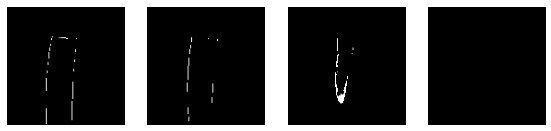

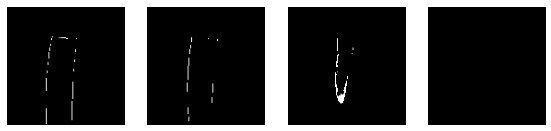

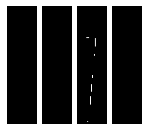

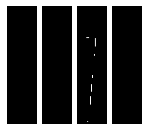

In [28]:
plt.rcParams['image.interpolation'] = 'hanning'
cost,oc,match1vol,match2vol = \
correspondVoxels((Enms>.1).astype(float),(GT).astype(float),.00001,10)

fig = plt.figure(figsize = (80,80))
plot_vol(match1vol>0,num_frames)
fig = plt.figure(figsize = (80,80))
plot_vol(match2vol>0,num_frames)

fig = plt.figure(figsize = (80,80))
plot_vol((match1vol>0).swapaxes(2,1),num_frames*4)

fig = plt.figure(figsize = (80,80))
plot_vol((match1vol>0).swapaxes(2,1),num_frames*4)

(128, 128, 32)


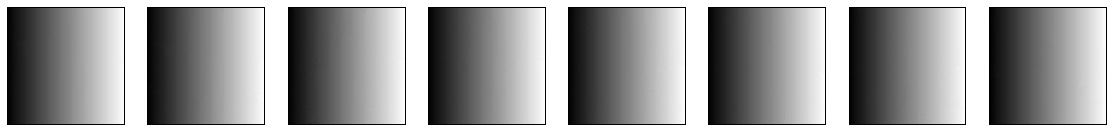

In [20]:
E = np.load("3dEdgeTest.npy")
E = normalimg(1-E)
from scipy.interpolate import interp1d
def interp3D(V, x, y, z, xi, yi, zi):
    B = np.zeros((max(x)+1,max(y)+1,max(z)+1))
    for xx,yy,zz,xxi,yyi,zzi in zip(x,y,z,xi,yi,zi):
        B[xx,yy,zz] = interp3(V,xxi,yyi,zzi)
    return B
    

print E.shape
x,y,z = range(0,E.shape[0]),range(0,E.shape[1]),range(0,E.shape[2])
X,Y,Z = np.meshgrid(x,y,z)
dX, dY, dZ, D = edgeOrientation(E,s=5)
# print x
# R = .95*np.concatenate((dX[...,np.newaxis],
#                         dY[...,np.newaxis],
#                         dZ[...,np.newaxis]),
#                        axis=3)
D1X,D1Y,D1Z = X+.95*dX,Y+.95*dY,Z+.95*dZ
# D2X,D2Y,D2Z = X-R,Y-R,Z-R
fig = plt.figure(figsize = (80,80))
plot_vol(D1X,8)

In [21]:
F1 = interp3D(E, X.ravel(), Y.ravel(), Z.ravel(),
              D1X.ravel(), D1Y.ravel(), D1Z.ravel())
# F1 = interp3(x, X, z, v, D1X, D1Y, D1Z)

In [22]:
fig = plt.figure(figsize = (80,80))
plot_vol(F1,8)

AttributeError: 'NoneType' object has no attribute 'min'

In [ ]:
B = np.zeros((K,K,K))
vmin,vmax = B.min(),B.max()
for xi,yi,zi in zip(X.ravel(),Y.ravel(),Z.ravel()):
    B[int(xi*N),int(yi*N),int(zi*N)] = interp3(A,xi,yi,zi)